# DOT Code Recognition Program - 1

## Loading Packages

In [ ]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import cv2

## Loading Model

In [14]:
# load the FCN model
print("[INFO] loading DOT code recognition model...")
model = load_model("/content/drive/MyDrive/Thesis-Tire DOT Code/edged_model.h5")

[INFO] loading DOT code recognition model...


## Loading Image Path

In [15]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread("/content/drive/MyDrive/Thesis-Tire DOT Code/test image 1.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

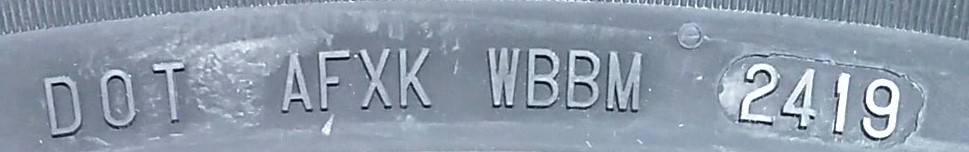

In [16]:
cv2_imshow(image)

## Image Processing

In [37]:
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 200, 150)                     # Deciding factor of text recognition accuracy
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

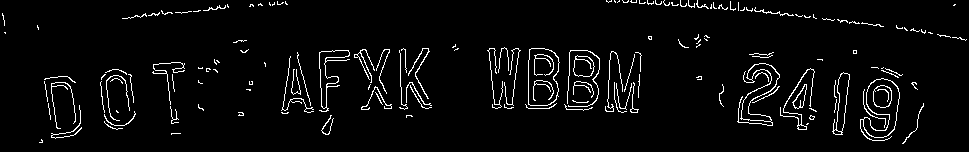

In [38]:
cv2_imshow(edged)

## Initialize the list of contour bounding boxes and associated


In [39]:
# characters that we'll be OCR'ing
chars = []

## Contour Detection

In [40]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

## Extracting Bounding Box

In [41]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

## Predicting Characters using FCN Model

In [42]:
# Recognizing characters using our DOT Code FCN recognition model
preds = model.predict(chars)

2/2 [==============================] - 0s 14ms/step


## Defining Labels

In [43]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

## Getting final output

In [44]:
from google.colab.patches import cv2_imshow
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)


[INFO] 4 - 27.98%
[INFO] H - 12.21%
[INFO] I - 25.99%
[INFO] I - 26.09%
[INFO] 8 - 9.34%
[INFO] 1 - 94.02%
[INFO] N - 32.56%
[INFO] U - 27.70%
[INFO] A - 61.07%
[INFO] L - 67.61%
[INFO] 1 - 86.17%
[INFO] H - 95.75%
[INFO] U - 16.94%
[INFO] H - 26.85%
[INFO] A - 99.91%
[INFO] 1 - 48.64%
[INFO] I - 96.71%
[INFO] 1 - 79.19%
[INFO] 1 - 53.22%
[INFO] I - 49.69%
[INFO] X - 43.35%
[INFO] I - 98.25%
[INFO] I - 21.82%
[INFO] J - 31.53%
[INFO] 3 - 50.39%
[INFO] B - 98.43%
[INFO] T - 91.41%
[INFO] T - 15.85%
[INFO] 1 - 30.99%
[INFO] I - 66.74%
[INFO] N - 27.22%
[INFO] I - 63.82%
[INFO] 1 - 76.80%
[INFO] 1 - 70.78%
[INFO] 1 - 48.06%
[INFO] 2 - 72.84%
[INFO] X - 95.55%
[INFO] 4 - 98.35%
[INFO] J - 22.26%
[INFO] 1 - 51.52%
[INFO] 9 - 86.00%
[INFO] C - 78.73%
[INFO] H - 49.25%


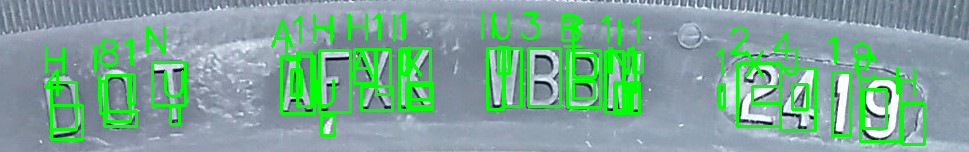

-1

In [45]:
	# show the image
cv2_imshow(image)
cv2.destroyAllWindows()
cv2.waitKey(0)

This is the final maximum output accuracy has been acquired using this FCN model. To get maximum possible output I have trained a frozen model using these trained model weights and labels and tested using Easyocr. 

Please refer "FCN frozen model using EasyOCR" folder to access coding scripts, models and output results of tire dot code recognition.